Imports:

In [1]:
from train_for_real import *

c:\Users\newma\AppData\Local\Programs\Python\Python310\lib\site-packages\timm\models\layers\__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
c:\Users\newma\AppData\Local\Programs\Python\Python310\lib\site-packages\timm\models\registry.py:4: FutureWarning: Importing from timm.models.registry is deprecated, please import via timm.models
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.models", FutureWarning)
c:\KU\SamPeft\finetuneSAM\models\sam\modeling\tiny_vit_sam.py:760: UserWarning: Overwriting tiny_vit_5m_224 in registry with finetuneSAM.models.sam.modeling.tiny_vit_sam.tiny_vit_5m_224. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  return register_model(fn_wrapper)
c:\KU\SamPeft\finetuneSAM\models\sam\modeling\tiny_vit

In [2]:
from finetuneSAM.cfg import parse_args
#Fine-Tune Sam
args =  parse_args()


# setting if_mask_decoder_adapter = True puts adapters inside 2-way transformer blocks
# this does not change the number of decoder 2-way transformer blocks (def = 2)
# decoder_adapt_depth denotes how many of the two 2-way transformer blocks are adapted


# setting if_encoder_adapter = True puts adapters inside TinyViTBlocks in the encoder
# this does not change the number of encoder TinyViTBlocks (def = 4)
# encoder_adapt_depth (e.g. [1,2]) denotes how deep blocks will be adapted

args.finetune_type = "vanilla"
args.finetune_type = "adapter"# "vanilla"
#args.if_mask_decoder_adapter = True
#args.image_size = 512
#args.decoder_adapt_depth = 1
args.num_cls = 3


sam = load_model(args)




c:\KU\SamPeft\finetuneSAM\models\sam\build_sam.py:158: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f)


In [3]:
import pickle
org_data = load_data()

# save dta as pickle
with open('data_w_ps.pkl', 'wb') as file:
    pickle.dump(org_data, file)


with open('data_w_ps.pkl', 'rb') as file:
    org_data = pickle.load(file)

sammy = Sammy(sam, (512,512))
print(len(org_data['image']))


distance applied:  45
distance applied:  45
distance applied:  45
distance applied:  45
2


In [4]:
batch_imgs = org_data['image'][0:2]
batch_masks = org_data['mask'][0:2]
batch_points = org_data['points'][0:2]
batch_p_labels = org_data['p_labels'][0:2]
features = sammy.encode_img(batch_imgs)
sparse_embeddings, dense_embeddings = sammy.encode_promts(batch_points, batch_p_labels)
iou_predictions, low_res_masks = sammy.decode_features(features, sparse_embeddings, dense_embeddings)






In [41]:

def visualize_predictions(true_mask, low_res_preds, points, p_labels):
    f = Upsample(scale_factor=0.5)
    # tru = org_data['mask'][0]
    # ponts = org_data['points'][0]
    # ponts = ponts * 0.5
    # lbls = org_data['p_labels'][0]

    tru = true_mask
    ponts = points
    ponts = ponts * 0.5
    lbls = p_labels
    

    tru = f(torch.tensor(tru)[None,None, :, :].float()).numpy()
    tru = tru[0][0]
    preds = low_res_masks[0].detach().cpu().numpy()
    preds = np.where(preds > 0.5, 1, 0)
    print(tru.shape)
    print(preds[0].shape)

    # plot three subplots each for tru and a class prediction
    fig, axs = plt.subplots(3,1)
    fig.suptitle('Predictions for Image 1')
    axs[0,].set_title('Prediction 1')
    tNp = tru + preds[0]*5
    axs[0].imshow(tNp)
    # scatter points   
    for i in range(len(ponts)):
        if lbls[i] == 1:
            axs[0].scatter(ponts[i][0], ponts[i][1], c='blue', s = 2)
        else:
            axs[0].scatter(ponts[i][0], ponts[i][1], c='red', s = 2)


    axs[1].set_title('Prediction 2')
    tNp = tru + preds[1]*5
    axs[1].imshow(tNp)
    # scatter points
    for i in range(len(ponts)):
        if lbls[i] == 1:
            axs[1].scatter(ponts[i][0], ponts[i][1], c='blue', s = 2)
        else:
            axs[1].scatter(ponts[i][0], ponts[i][1], c='red', s = 2)


    axs[2].set_title('Prediction 3')
    tNp = tru + preds[2]*5
    axs[2].imshow(tNp)
    # scatter points with size 2pxs
    for i in range(len(ponts)):
        if lbls[i] == 1:
            axs[2].scatter(ponts[i][0], ponts[i][1], c='blue', s = 2)
        else:
            axs[2].scatter(ponts[i][0], ponts[i][1], c='red', s = 2)
    plt.show()






# # 3 masks for 3 classes
# img1_masks = low_res_masks[0]
# # # # plot low res masks
# plt.imshow(img1_masks[].detach().cpu().numpy())
# plt.show()

(256, 256)
(256, 256)


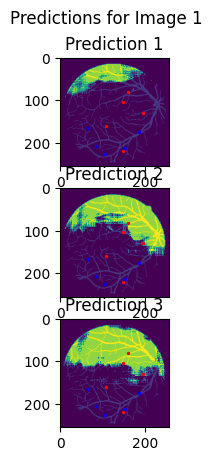

In [43]:
visualize_predictions(batch_masks[1], low_res_masks[1], batch_points[1], batch_p_labels[1])

In [6]:
# #Scientific computing 
# import numpy as np
# #Pytorch packages
# import torch
from torch import nn
import torch.optim as optim
from tensorboardX import SummaryWriter
#Visulization
from tqdm import tqdm
import monai


In [ ]:
from finetuneSAM.utils.dsc import dice_coeff_multi_class

sam = sam
data = {"image":[],"mask":[],"t_points":[],"bg_points":[]}
data['image'] = org_data['image'].copy()
data['mask'] = org_data['mask'].copy()
data['t_points'] = org_data['t_points'].copy()
data['bg_points'] = org_data['bg_points'].copy()

train_points = len(data['image'])
checkpoints_path = 'checkpoints'


val_percentage = 0.15
val_points = int(train_points*val_percentage)
train_points = train_points - val_points
print('Train points:',train_points)

val_data = {"image":[],"mask":[],"t_points":[],"bg_points":[]}
for i in range(val_points):
    rnd_indx = np.random.randint(0,len(data["image"])-1)
    val_data["image"].append(data["image"].pop(rnd_indx))
    val_data["mask"].append(data["mask"].pop(rnd_indx))
    val_data["t_points"].append(data["t_points"].pop(rnd_indx))
    val_data["bg_points"].append(data["bg_points"].pop(rnd_indx))
    

if args.finetune_type == 'adapter':
    for n, value in sam.named_parameters():
        if "Adapter" not in n: # only update parameters in adapter
            value.requires_grad = False
    print('if update encoder:',args.if_update_encoder)
    print('if image encoder adapter:',args.if_encoder_adapter)
    print('if mask decoder adapter:',args.if_mask_decoder_adapter)
    if args.if_encoder_adapter:
        print('added adapter layers:',args.encoder_adapter_depths)
    
# elif args.finetune_type == 'vanilla' and args.if_update_encoder==False:   
#     print('if update encoder:',args.if_update_encoder)
#     for n, value in sam.image_encoder.named_parameters():
#         value.requires_grad = False
# elif args.finetune_type == 'lora':
#     print('if update encoder:',args.if_update_encoder)
#     print('if image encoder lora:',args.if_encoder_lora_layer)
#     print('if mask decoder lora:',args.if_decoder_lora_layer)
#     sam = LoRA_Sam(args,sam,r=4).sam
sam.to('cuda')
b_lr = args.lr
epochs = 32
batch_size = 5

def randomly_divide_into_batches(data,batch_size):
    num_batches = len(data)//batch_size
    if len(data)%batch_size!=0:
        num_batches+=1
    batches = []
    for i in range(num_batches):
        batches.append(data[i*batch_size:(i+1)*batch_size])
    return batches

b_lr = 1e-3
optimizer = optim.AdamW(sam.parameters(), lr=b_lr, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.1, amsgrad=False)
optimizer.zero_grad()
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5) #learning rate decay
criterion1 = monai.losses.DiceLoss(sigmoid=True, squared_pred=True, to_onehot_y=True,reduction='mean')
criterion2 = nn.CrossEntropyLoss()
iter_num = 0
max_iterations = epochs * train_points
writer = SummaryWriter(checkpoints_path + '/log')

pbar = tqdm(range(epochs))
val_largest_dsc = 0
last_update_epoch = 0
print('Start training')
for epoch in pbar:
    print('Epoch num {}'.format(epoch))
    sam.train()
    train_loss = 0
    for i in range(train_points):
        
        imgs = data['image'][i]
        msks = data['mask'][i]
        t_ps = data['t_points'][i]
        bg_ps = data['bg_points'][i]

        sammy.set_image(imgs)

        if args.if_update_encoder:
            #img_emb = sam.image_encoder(imgs)
            img_emb = sammy.encode_img()
        else:
            with torch.no_grad():
                #img_emb = sam.image_encoder(imgs)
                img_emb = sammy.encode_img()
        
        sparse_emb, dense_emb = sammy.encode_promts(t_ps,bg_ps)
        pred, _,_ = sammy.decode_features(img_emb, sparse_emb, dense_emb)

        msks_t = torch.tensor([msks])
        msks_t = torch.squeeze(msks_t.long(),1).cuda()
        pred_t = pred.argmax(dim=1)

        loss_dice =  1 - dice_coeff_multi_class(pred_t, msks_t,2)
        loss_ce = criterion2(pred,torch.tensor([msks]).long().cuda())
        loss =  loss_dice + loss_ce

        # print(' dice loss:',loss_dice)
        # print(' ce loss:',loss_ce)
        
        loss.backward()
        optimizer.step()
        optimizer.zero_grad(set_to_none=True)

        
        if args.if_warmup and iter_num < args.warmup_period:
            lr_ = args.lr * ((iter_num + 1) / args.warmup_period)
            for param_group in optimizer.param_groups:
                param_group['lr'] = lr_

        else:
            if args.if_warmup:
                shift_iter = iter_num - args.warmup_period
                assert shift_iter >= 0, f'Shift iter is {shift_iter}, smaller than zero'
                lr_ = args.lr * (1.0 - shift_iter / max_iterations) ** 0.9  # learning rate adjustment depends on the max iterations
                for param_group in optimizer.param_groups:
                    param_group['lr'] = lr_
            else:
                lr_ = args.lr

        train_loss += loss.item()
        iter_num+=1
        writer.add_scalar('info/lr', lr_, iter_num)
        writer.add_scalar('info/total_loss', loss, iter_num)
        writer.add_scalar('info/loss_ce', loss_ce, iter_num)
        #writer.add_scalar('info/loss_dice', loss_dice, iter_num)

    train_loss /= (i+1)
    pbar.set_description('Epoch num {}| train loss {} \n'.format(epoch,train_loss))

    if epoch%2==0:
        
        eval_loss=0
        dsc = 0
        sam.eval()
        with torch.no_grad():
            for i in range(val_points):
                #print('Validation point num {}'.format(i))
                imgs = val_data['image'][i]
                msks = val_data['mask'][i]
                sammy.set_image(imgs)

                        #img_emb = sam.image_encoder(imgs)
                img_emb = sammy.encode_img()
                
                sparse_emb, dense_emb = sammy.encode_promts(data['t_points'][i], data['bg_points'][i])
                
                pred, _,_ = sammy.decode_features(img_emb, sparse_emb, dense_emb)
                
                msks_t = torch.tensor([msks])
                msks_t = torch.squeeze(msks_t.long(),1).cuda()
                pred_t = pred.argmax(dim=1)
                loss_dice =  1 - dice_coeff_multi_class(pred_t, msks_t,2)
                loss_ce = criterion2(pred,torch.tensor([msks]).long().cuda())
                loss = loss_dice + loss_ce
                
                eval_loss +=loss.item()
                dsc_batch = dice_coeff_multi_class(pred_t, msks_t,2)
                dsc+=dsc_batch
                #print(dsc_batch)

            eval_loss /= (i+1)
            dsc /= (i+1)
            
            writer.add_scalar('eval/loss', eval_loss, epoch)
            writer.add_scalar('eval/dice', dsc, epoch)
            
            print('Eval Epoch num {} | val loss {} | dsc {} \n'.format(epoch,eval_loss,dsc))
            if dsc>val_largest_dsc:
                val_largest_dsc = dsc
                last_update_epoch = epoch
                print('largest DSC now: {}'.format(dsc))
                torch.save(sam.state_dict(),checkpoints_path + '/checkpoint_best.pth')
            elif (epoch-last_update_epoch)>20:
                # the network haven't been updated for 20 epochs
                print('Training finished###########')
                break
writer.close()

Train points: 64


  0%|          | 0/32 [00:00<?, ?it/s]

Start training
Epoch num 0


Epoch num 0| train loss 0.8428937420248985 
Epoch num 0| train loss 0.8428937420248985 
:   3%|▎         | 1/32 [00:10<05:12, 10.09s/it]

Eval Epoch num 0 | val loss 0.8664942756295204 | dsc 0.4677097797393799 

largest DSC now: 0.4677097797393799
Epoch num 1


Epoch num 1| train loss 0.8419468402862549 
Epoch num 1| train loss 0.8419468402862549 s/it]
:   6%|▋         | 2/32 [00:17<04:23,  8.80s/it]

Epoch num 2


Epoch num 2| train loss 0.8418556293472648 
Epoch num 2| train loss 0.8418556293472648 s/it]
:   9%|▉         | 3/32 [00:27<04:22,  9.04s/it]

Eval Epoch num 2 | val loss 0.8670331723988056 | dsc 0.4686797261238098 

largest DSC now: 0.4686797261238098
Epoch num 3


Epoch num 3| train loss 0.8422230537980795 
Epoch num 3| train loss 0.8422230537980795 s/it]
:  12%|█▎        | 4/32 [00:35<04:02,  8.65s/it]

Epoch num 4


Epoch num 4| train loss 0.8404996562749147 
Epoch num 4| train loss 0.8404996562749147 s/it]
:  16%|█▌        | 5/32 [00:44<04:02,  8.98s/it]

Eval Epoch num 4 | val loss 0.8662577979266644 | dsc 0.4704669415950775 

largest DSC now: 0.4704669415950775
Epoch num 5


Epoch num 5| train loss 0.8404936362057924 
Epoch num 5| train loss 0.8404936362057924 s/it]
:  19%|█▉        | 6/32 [00:52<03:43,  8.60s/it]

Epoch num 6


Epoch num 6| train loss 0.8386591915041208 
Epoch num 6| train loss 0.8386591915041208 s/it]
:  22%|██▏       | 7/32 [01:02<03:43,  8.95s/it]

Eval Epoch num 6 | val loss 0.8652823865413666 | dsc 0.47362765669822693 

largest DSC now: 0.47362765669822693
Epoch num 7


Epoch num 7| train loss 0.8369312956929207 
Epoch num 7| train loss 0.8369312956929207 s/it]
:  25%|██▌       | 8/32 [01:10<03:26,  8.60s/it]

Epoch num 8


Epoch num 8| train loss 0.837428005412221 
Epoch num 8| train loss 0.837428005412221 0s/it] 
:  28%|██▊       | 9/32 [01:19<03:24,  8.88s/it]

Eval Epoch num 8 | val loss 0.8672641441226006 | dsc 0.47201529145240784 

Epoch num 9


Epoch num 9| train loss 0.8372627403587103 
Epoch num 9| train loss 0.8372627403587103 s/it]
:  31%|███▏      | 10/32 [01:27<03:08,  8.57s/it]

Epoch num 10


Epoch num 10| train loss 0.8371526254341006 
Epoch num 10| train loss 0.8371526254341006 s/it]
:  34%|███▍      | 11/32 [01:37<03:05,  8.85s/it]

Eval Epoch num 10 | val loss 0.8669195845723152 | dsc 0.46986180543899536 

Epoch num 11


Epoch num 11| train loss 0.8370154462754726 
Epoch num 11| train loss 0.8370154462754726 s/it]
:  38%|███▊      | 12/32 [01:45<02:51,  8.57s/it]

Epoch num 12


Epoch num 12| train loss 0.8346148692071438 
Epoch num 12| train loss 0.8346148692071438 s/it]
:  41%|████      | 13/32 [01:54<02:50,  8.95s/it]

Eval Epoch num 12 | val loss 0.8647603094577789 | dsc 0.47533756494522095 

largest DSC now: 0.47533756494522095
Epoch num 13


Epoch num 13| train loss 0.8354831291362643 
Epoch num 13| train loss 0.8354831291362643 s/it]
:  44%|████▍     | 14/32 [02:02<02:34,  8.60s/it]

Epoch num 14


Epoch num 14| train loss 0.8338388577103615 
Epoch num 14| train loss 0.8338388577103615 s/it]
:  47%|████▋     | 15/32 [02:12<02:31,  8.92s/it]

Eval Epoch num 14 | val loss 0.8637801371514797 | dsc 0.479053258895874 

largest DSC now: 0.479053258895874
Epoch num 15


Epoch num 15| train loss 0.8364048665389419 
Epoch num 15| train loss 0.8364048665389419 s/it]
:  50%|█████     | 16/32 [02:20<02:17,  8.59s/it]

Epoch num 16


Epoch num 16| train loss 0.8351644575595856 
Epoch num 16| train loss 0.8351644575595856 s/it]
:  53%|█████▎    | 17/32 [02:29<02:12,  8.85s/it]

Eval Epoch num 16 | val loss 0.865853238850832 | dsc 0.47116783261299133 

Epoch num 17


Epoch num 17| train loss 0.8347692349925637 
Epoch num 17| train loss 0.8347692349925637 s/it]
:  56%|█████▋    | 18/32 [02:37<02:00,  8.62s/it]

Epoch num 18


Epoch num 18| train loss 0.8331492720171809 
Epoch num 18| train loss 0.8331492720171809 s/it]
:  59%|█████▉    | 19/32 [02:47<01:55,  8.91s/it]

Eval Epoch num 18 | val loss 0.8644380457699299 | dsc 0.47476479411125183 

Epoch num 19


Epoch num 19| train loss 0.8323844745755196 
Epoch num 19| train loss 0.8323844745755196 s/it]
:  62%|██████▎   | 20/32 [02:55<01:42,  8.57s/it]

Epoch num 20


Epoch num 20| train loss 0.8322675079107285 
Epoch num 20| train loss 0.8322675079107285 s/it]
:  66%|██████▌   | 21/32 [03:04<01:36,  8.80s/it]

Eval Epoch num 20 | val loss 0.8641957640647888 | dsc 0.4762236177921295 

Epoch num 21


Epoch num 21| train loss 0.8321861820295453 
Epoch num 21| train loss 0.8321861820295453 s/it]
:  69%|██████▉   | 22/32 [03:12<01:24,  8.49s/it]

Epoch num 22


Epoch num 22| train loss 0.8319104369729757 
Epoch num 22| train loss 0.8319104369729757 s/it]
:  72%|███████▏  | 23/32 [03:21<01:19,  8.80s/it]

Eval Epoch num 22 | val loss 0.8653239943087101 | dsc 0.4733722507953644 

Epoch num 23


Epoch num 23| train loss 0.8318500090390444 
Epoch num 23| train loss 0.8318500090390444 s/it]
:  75%|███████▌  | 24/32 [03:29<01:07,  8.43s/it]

Epoch num 24


Epoch num 24| train loss 0.829756086692214 
Epoch num 24| train loss 0.829756086692214 3s/it] 
:  78%|███████▊  | 25/32 [03:38<01:00,  8.61s/it]

Eval Epoch num 24 | val loss 0.8658473193645477 | dsc 0.4743642210960388 

Epoch num 25


Epoch num 25| train loss 0.830324973911047 
Epoch num 25| train loss 0.830324973911047 1s/it]
:  81%|████████▏ | 26/32 [03:45<00:49,  8.31s/it]

Epoch num 26


Epoch num 26| train loss 0.8317833580076694 
Epoch num 26| train loss 0.8317833580076694 s/it]
:  84%|████████▍ | 27/32 [03:55<00:43,  8.63s/it]

Eval Epoch num 26 | val loss 0.8674727603793144 | dsc 0.47102394700050354 

Epoch num 27


Epoch num 27| train loss 0.8309591049328446 
Epoch num 27| train loss 0.8309591049328446 s/it]
:  88%|████████▊ | 28/32 [04:02<00:33,  8.33s/it]

Epoch num 28


Epoch num 28| train loss 0.8287690430879593 
Epoch num 28| train loss 0.8287690430879593 s/it]
:  91%|█████████ | 29/32 [04:12<00:25,  8.58s/it]

Eval Epoch num 28 | val loss 0.8642044998705387 | dsc 0.47576963901519775 

Epoch num 29


Epoch num 29| train loss 0.8289056895300746 
Epoch num 29| train loss 0.8289056895300746 s/it]
:  94%|█████████▍| 30/32 [04:19<00:16,  8.34s/it]

Epoch num 30


Epoch num 30| train loss 0.8286013305187225 
Epoch num 30| train loss 0.8286013305187225 s/it]
:  97%|█████████▋| 31/32 [04:29<00:08,  8.61s/it]

Eval Epoch num 30 | val loss 0.8640174381434917 | dsc 0.477622389793396 

Epoch num 31


Epoch num 31| train loss 0.828446744941175 
Epoch num 31| train loss 0.828446744941175 1s/it] 
Epoch num 31| train loss 0.828446744941175 4s/it]
: 100%|██████████| 32/32 [04:36<00:00,  8.65s/it]


In [7]:
batch = np.ones((5,512,512,3))
batch_tr = torch.tensor(batch)
batch_tr = batch_tr.permute(0,3,1,2)

f = Upsample(scale_factor=2.0)

print(batch_tr.shape)

batch_up = f(batch_tr)

print(batch_up.shape)



torch.Size([5, 3, 512, 512])
torch.Size([5, 3, 1024, 1024])


In [10]:
# B x Plane x N x 2
pss = np.ones((5,2,10,2))
pss*2
# B x Plane * N x 2
pss_all = np.ones((5,20,2))


lblss = np.ones((5,20))




array([[[[2., 2.],
         [2., 2.],
         [2., 2.],
         [2., 2.],
         [2., 2.],
         [2., 2.],
         [2., 2.],
         [2., 2.],
         [2., 2.],
         [2., 2.]],

        [[2., 2.],
         [2., 2.],
         [2., 2.],
         [2., 2.],
         [2., 2.],
         [2., 2.],
         [2., 2.],
         [2., 2.],
         [2., 2.],
         [2., 2.]]],


       [[[2., 2.],
         [2., 2.],
         [2., 2.],
         [2., 2.],
         [2., 2.],
         [2., 2.],
         [2., 2.],
         [2., 2.],
         [2., 2.],
         [2., 2.]],

        [[2., 2.],
         [2., 2.],
         [2., 2.],
         [2., 2.],
         [2., 2.],
         [2., 2.],
         [2., 2.],
         [2., 2.],
         [2., 2.],
         [2., 2.]]],


       [[[2., 2.],
         [2., 2.],
         [2., 2.],
         [2., 2.],
         [2., 2.],
         [2., 2.],
         [2., 2.],
         [2., 2.],
         [2., 2.],
         [2., 2.]],

        [[2., 2.],
         [2., 2.]